In [1]:
import numpy as np
pi = np.pi
pi2i = pi*2j
from matplotlib import pyplot as plt
from time import time
from scipy.sparse.linalg import gmres

In [2]:
# some aux functions
def cplx2tuple(z):
    return np.real(z), np.imag(z)

# intro
I solved the interior 2d stokes problem on the ellipse in this jupyter notebook, which serves as a basis for further solution of this problem

$$
\theta \to 2\cos(\theta) + i\sin(\theta)
$$

In [5]:
# number of points
n = 64

# points on the interval [0,2*pi] as parametrization 
a = np.linspace(0,2*np.pi,n+1)[:-1]
# step-size, this can either be a single scalar in case of arc-length parametrization, or a sequence otherwise. 
h = 2*np.pi / n

# complex coordinates of points on the curve 
t = 2*np.cos(a) + 1j*np.sin(a)

# parametrization derivatives
dx_da = -2*np.sin(a)
dx_da_2 = -2*np.cos(a)
dy_da = np.cos(a)
dy_da_2 = -np.sin(a)
dt_da = dx_da + 1j*dy_da

# boundary conditions
v = np.zeros(n)
u = 1-(t.imag)**2
h2 = u
h1 = -v

# curvature, this is the curvature of unit circle. 
curvature = (dx_da*dy_da_2 - dy_da*dx_da_2)/((dx_da**2 + dy_da**2)**(1.5))

the blue dots is equal-space pts on the boundary $\Gamma=S^1$, the red line is vector field of velocity, the green line is the tangential derivatives. the yellow line is the normal derivatives


The velocity is the normalized presoille flow with integration = 1

The kernels and BI eq can be greatly simplified in this specific case, compare to the original case in L. Greengard's paper. In this case, it is 

$$
K_1'(t_i,t_j) = \frac{-h}{\pi} \Im(\frac{d_j}{dt})\\
K_2'(t_i,t_j) = \frac{-h}{2\pi i} (\frac{-d_j}{\bar{dt}} + \frac{\bar{d_j}dt}{\bar{dt}^2}) 
$$ 
where $dt = t_i-t_j$, $d_j$ is the derivative of the parametrization. 

And in the limiting case of $i=j$, the kernels should be 

$$
K_1'(t_i,t_i) = \frac{h}{2\pi}\kappa_i |d_i| \\
K_2'(t_i,t_i) = \frac{-h}{2\pi} \kappa_i d_i^2/ |d_i|
$$

In [6]:
def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -h * np.imag(d/dt) / np.pi
        K2 = -h * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [7]:
K1, K2 = kernels(t,dt_da,h,curvature)

this calculation can be vectorized for speeding up, but I guess it needs to handle the case of i == j more carefully. 

My integral equation does not contain any singular term, this could lead to inaccuracy and convergence, I guess. 

Should I transfer this into a real equation for the solution?? Or is it I can just live with the complex equation? How to deal with the complex conjugates though... 

The integral equation is of the following form

$$
(I+K_1+K_2\mathfrak C) \omega = h
$$ where $\mathfrak C$ is a symbol for conjugation. 

This can be discreticized in the the points of our choice and then seperate the real and imaginary matrix equation so that 

$$
\begin{pmatrix}
I+\Re(K_1+K_2) & \Im(-K_1+K_2) \\
\Im(K_1 + K_2) & I+\Re(K_1-K_2)
\end{pmatrix}
\begin{pmatrix}
\Re \omega\\
\Im \omega
\end{pmatrix} = 
\begin{pmatrix}
\Re h\\
\Im h
\end{pmatrix}
$$

In [8]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real

In [9]:
rhs = np.concatenate((h1,h2))

In [10]:
omega,_ = gmres(A,rhs)
#omega = np.linalg.solve(A,rhs)

In [12]:
omega = omega[:n] + 1j*omega[n:]

In [13]:
def evaluation(z,omega,t,h,dt_da):
    
    d_t = dt_da*h
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW

# error analysis

Let's pretend that $5h$ rule is true in this case. since $5h = \frac{5\cdot4\cdot\pi}{64} = \frac{20\cdot\pi}{64} \approx 1$, so we should not expect good convergence. 

# error on points $|z|\le 0.5$


In [44]:
grid_density = 1000
radius = 0.5
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
grid = np.array([(x,y) for x in np.linspace(-2,2,grid_density) for y in np.linspace(-1,1,grid_density) if x**2/4 + y**2 <= radius**2])
grid_X, grid_Y = grid.T
grid_t = grid_X + 1j*grid_Y

grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in grid_t])
true_values = 1j*np.array([1-y**2 for x,y in grid])

error = (np.abs(grid_values - true_values))
relative_error = error/np.abs(true_values)

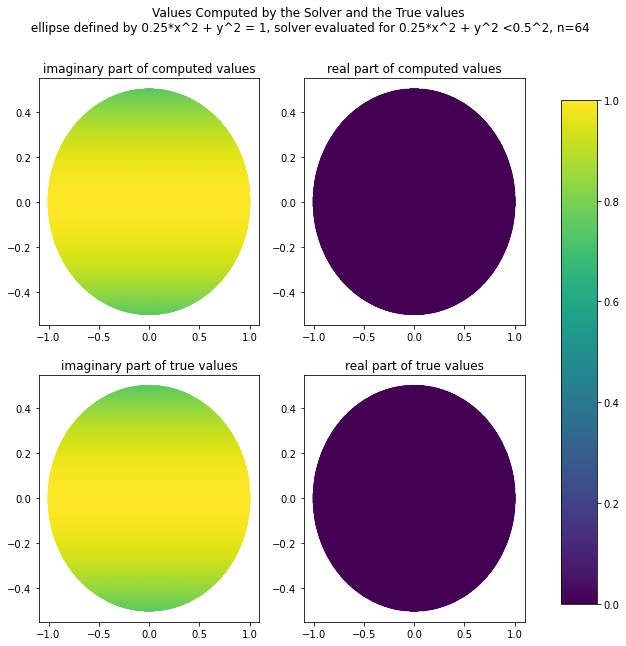

In [49]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=grid_X,y=grid_Y,c=grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=grid_X,y=grid_Y,c=grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=grid_X,y=grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=grid_X,y=grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Values Computed by the Solver and the True values\n ellipse defined by 0.25*x^2 + y^2 = 1, solver evaluated for 0.25*x^2 + y^2 <' + str(radius) + '^2'+ ', n=' + str(n))
print()

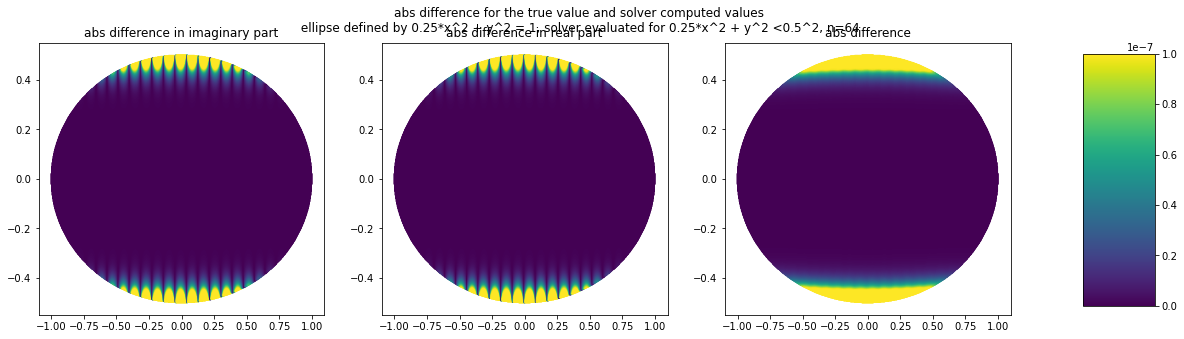

In [50]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values).imag),s=1,vmin=0,vmax=1e-7)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values).real),s=1,vmin=0,vmax=1e-7)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values)),s=1,vmin=0,vmax=1e-7)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('abs difference for the true value and solver computed values\n ellipse defined by 0.25*x^2 + y^2 = 1, solver evaluated for 0.25*x^2 + y^2 <' + str(radius) + '^2'+ ', n=' + str(n))
print()

In [51]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 64 r= 0.5
error for velocity
max 6.486548242282891e-07 	mean 1.5638423009705796e-08
relative error for velocity: mean and max
max 8.642966131303829e-07 	mean 1.978195525830209e-08


This convergence is not bad

# error on points $|z|\le 0.8$

In [52]:
grid_density = 1000
radius = 0.8
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
grid = np.array([(x,y) for x in np.linspace(-2,2,grid_density) for y in np.linspace(-1,1,grid_density) if x**2/4 + y**2 <= radius**2])
grid_X, grid_Y = grid.T
grid_t = grid_X + 1j*grid_Y

grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in grid_t])
true_values = 1j*np.array([1-y**2 for x,y in grid])

error = (np.abs(grid_values - true_values))
relative_error = error/np.abs(true_values)

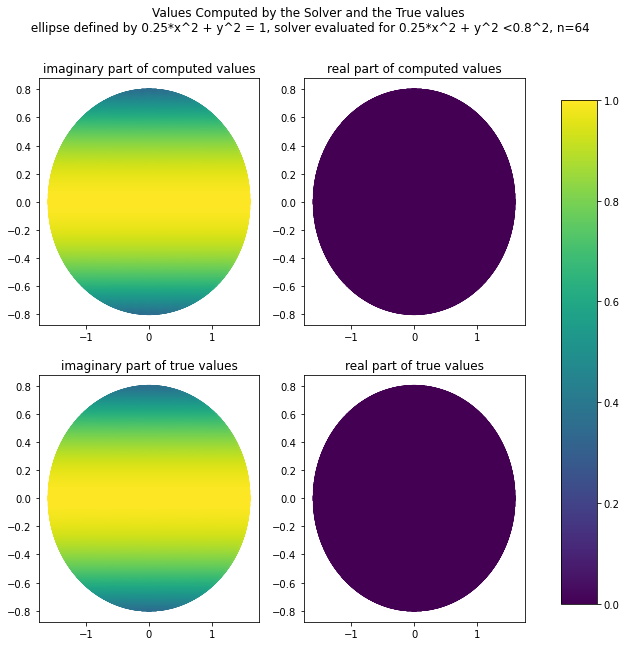

In [53]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=grid_X,y=grid_Y,c=grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=grid_X,y=grid_Y,c=grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=grid_X,y=grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=grid_X,y=grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Values Computed by the Solver and the True values\n ellipse defined by 0.25*x^2 + y^2 = 1, solver evaluated for 0.25*x^2 + y^2 <' + str(radius) + '^2'+ ', n=' + str(n))
print()

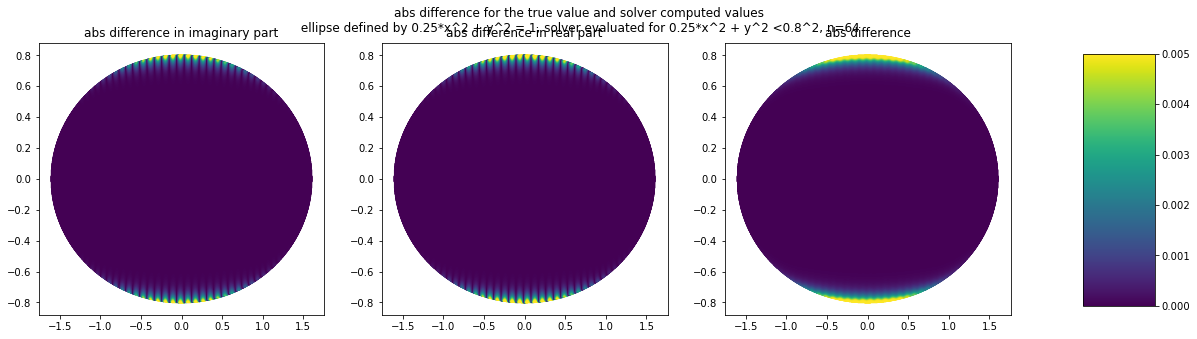

In [54]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values).imag),s=1,vmin=0,vmax=0.005)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values).real),s=1,vmin=0,vmax=0.005)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=grid_X,y=grid_Y,c=np.abs((grid_values-true_values)),s=1,vmin=0,vmax=0.005)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('abs difference for the true value and solver computed values\n ellipse defined by 0.25*x^2 + y^2 = 1, solver evaluated for 0.25*x^2 + y^2 <' + str(radius) + '^2'+ ', n=' + str(n))
print()

In [39]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 64 r= 0.8
error for velocity
max 0.008294307268563669 	mean 0.00015080196602854215
relative error for velocity: mean and max
max 0.023019262926401038 	mean 0.0003399111716796178


This is far from machine precision. 